# Training

### Imports

In [27]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO

from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from test_utils import *
from train_utils import *
from orchestrator import *
import pandas as pd

%load_ext autoreload
%autoreload 2 

plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train non-delayed agents

### Train a single agent

In [ ]:
env_class = SphericalTank
seed = 0

# Setpoint dict for the environments
setpoint_dict = {
    'LinearVelocity' : 2.703,
    'NonLinearVelocity' :  2.703,
    'Position' : [0.0, 2.703],
    'RobotSteer' :[0.0,2.703, 2.703,0.0],
    'SphericalTank' : 2.703
}



setpoint = setpoint_dict[env_class.__name__]
if isinstance(setpoint, float): 
        setpoint = [setpoint]

core_env = env_class(seed=seed, desired_state=np.array(setpoint))

agent_type = 'sac'
n_episodes = 20
observation_type = 'setpoint-error'
randomise_setpoint = True

# By default the observation is rescaled for all environments except the RobotSteer
rescale_observation = core_env.__class__.__name__ != 'RobotSteer'


agent, env = train_default_agent(core_env = core_env, 
                                 agent_type= agent_type,
                                 desired_state= setpoint, 
                                 seed = seed, 
                                 n_episodes = n_episodes, 
                                 observation_type= observation_type, 
                                 randomise_setpoint= randomise_setpoint, 
                                 rescale_observation= rescale_observation)

### Train with different seeds
Each seed corresponds to one setpoint which is set only for saving purposes if the setpoint is randomised during training. 

In [ ]:
env_class = SphericalTank
seeds = [0, 42, 85]
# Setpoint dict for the environments
setpoint_dict_seeds = {
    'LinearVelocity' : [2.7031,2.7032, 2.7033],
    'NonLinearVelocity' :  [ 2.7031 ,2.7032, 2.7033],
    'Position' : [[0.0, 2.7031], [0.0, 2.7032], [0.0, 2.7033]],
    'RobotSteer' :[[0.0,2.7031, 2.7031,0.0], [0.0,2.7032, 2.7032,0.0], [0.0,2.7033, 2.7033,0.0]],
    'SphericalTank' : [2.7031,2.7032, 2.7033]
}

agent_type = 'sac'
n_episodes = 200
observation_type = 'setpoint-error'
randomise_setpoint = True


for i, seed in enumerate(seeds) :
    setpoint = setpoint_dict_seeds[env_class.__name__][i]
    if isinstance(setpoint, float): 
        setpoint = [setpoint]
    core_env = env_class(desired_state=np.array(setpoint), seed = seed)
    # By default the observation is rescaled for all environments except the RobotSteer
    rescale_observation = core_env.__class__.__name__ != 'RobotSteer'

    agent, env = train_default_agent(core_env = core_env, 
                                    agent_type='sac',
                                    desired_state= setpoint, 
                                    seed = seed, 
                                    n_episodes = n_episodes, 
                                    observation_type= observation_type, 
                                    randomise_setpoint= randomise_setpoint, 
                                    rescale_observation= rescale_observation)

## Delay-safe agents
If there exists a non-delayed agent for the setpoint, it will be loaded. Otherwise a new expert critic will be trained, but this part can be modified - it is also fine to load another critic, but was prepared like this to keep the safe agents consistent with the critics. 

### Train a single agent

In [ ]:
env_class = SphericalTank
seed = 0

agent_type = 'sac'
safe_agent_type = 'dqsac'
# Whether to use average or min Q
avg_q = False
n_episodes = 20
observation_type = 'setpoint-error'
randomise_setpoint = True

# Whether to use random delay for safe agent training
random_delay = True

# Entropy coefficient for the safe agent
ent_coef = 0.5

# Setpoint dict for the environments
setpoint_dict = {
    'LinearVelocity' : 2.703,
    'NonLinearVelocity' :  2.703,
    'Position' : [0.0, 2.703],
    'RobotSteer' :[0.0,2.703, 2.703,0.0],
    'SphericalTank' : 2.703
}

setpoint = setpoint_dict[env_class.__name__]
if isinstance(setpoint, float): 
        setpoint = [setpoint]

core_env = env_class(seed=seed, desired_state=np.array(setpoint))

# By default the observation is rescaled for all environments except the RobotSteer
rescale_observation = core_env.__class__.__name__ != 'RobotSteer'
randomised_str = 'randomised' if randomise_setpoint else 'fixed'
try :
  agent = SAC.load(f'models\\{env_class.__name__}\\{observation_type}\\{randomised_str}\\Desired{setpoint}\sac.zip')
except: 
  agent, env = train_default_agent(core_env = core_env, 
                                 agent_type= agent_type,
                                 desired_state= setpoint, 
                                 seed = seed, 
                                 n_episodes = n_episodes, 
                                 observation_type= observation_type, 
                                 randomise_setpoint= randomise_setpoint, 
                                 rescale_observation= rescale_observation)


if avg_q == False and agent_type == 'augsac':
    print(f"Training Augmented SAC with min Q is the same as using average.")
      
safe_agent, env, delay_history, setpoint_history = train_default_augmented_agent(core_env = core_env, 
                                              agent_type= safe_agent_type,
                                              desired_state= setpoint,
                                              seed = seed,
                                              observation_type= observation_type,
                                              randomise_setpoint= randomise_setpoint, 
                                              random_delay= random_delay,
                                              average_q=avg_q,
                                              n_episodes= n_episodes, 
                                              ent_coef= ent_coef,
                                              undelayed_critic=agent.critic)





### Training loop for all safe agents with different seeds

In [ ]:
setpoint_dict_seeds = {
    'LinearVelocity' : [2.7031,2.7032, 2.7033],
    'NonLinearVelocity' :  [ 2.7031 ,2.7032, 2.7033],
    'Position' : [[0.0, 2.7031], [0.0, 2.7032], [0.0, 2.7033]],
    'RobotSteer' :[[0.0,2.7031, 2.7031,0.0], [0.0,2.7032, 2.7032,0.0], [0.0,2.7033, 2.7033,0.0]],
    'SphericalTank' : [2.7031,2.7032, 2.7033]
}

seeds = [0, 42, 85]
agent_type = 'sac'
safe_agent_types = ['dqsac', 'aqsac', 'augsac']

n_episodes = 5
observation_type = 'setpoint-error'
randomise_setpoint = True

# Whether to use random delay for safe agent training
random_delay = True

# Entropy coefficient for the safe agent
ent_coef = 0.5

for i, seed in enumerate(seeds): 
    setpoint = setpoint_dict_seeds[env_class.__name__][i]
    if isinstance(setpoint, float): 
        setpoint = [setpoint]

    core_env = env_class(desired_state=np.array(setpoint), seed = seed)
    # By default the observation is rescaled for all environments except the RobotSteer
    rescale_observation = core_env.__class__.__name__ != 'RobotSteer'
    randomised_str = 'randomised' if randomise_setpoint else 'fixed'

    try :
        agent = SAC.load(f'models\\{env_class.__name__}\\{observation_type}\\{randomised_str}\\Desired{setpoint}\sac.zip')
    except: 
        agent, env = train_default_agent(core_env = core_env, 
                                 agent_type= agent_type,
                                 desired_state= setpoint, 
                                 seed = seed, 
                                 n_episodes = n_episodes, 
                                 observation_type= observation_type, 
                                 randomise_setpoint= randomise_setpoint, 
                                 rescale_observation= rescale_observation)

    for safe_agent_type in safe_agent_types: 
        for avg_q in [True, False]:
            if avg_q == False and safe_agent_type == 'augsac':
                print(f"Training Augmented SAC with min Q is the same as using average.")
                continue
            
            safe_agent, env, delay_history, setpoint_history = train_default_augmented_agent(core_env = core_env, 
                                                    agent_type= safe_agent_type,
                                                    desired_state= setpoint,
                                                    seed = seed,
                                                    observation_type= observation_type,
                                                    randomise_setpoint= randomise_setpoint, 
                                                    random_delay= random_delay,
                                                    average_q=avg_q,
                                                    n_episodes= n_episodes, 
                                                    ent_coef= ent_coef,
                                                    undelayed_critic=agent.critic)

# Plot training

## Simple environments

### Non-delayed agents trained during the thesis work
To load new trained agents change the setpoints, and dates dictionatries. 

In [28]:
env_dates_dict = {
    'LinearVelocity' : ['0614','0614','0614'], 
    'NonLinearVelocity' : ['0614','0614','0615'], 
    'Position' : ['0615','0615','0615'], 
    'RobotSteer' : ['0619','0619','0619'],
    'SphericalTank' : ['0626','0626','0626']
}

setpoints = [2.6141, 2.6142, 2.6143]
env_setpoint_dict = {
    'LinearVelocity' : setpoints, 
    'NonLinearVelocity' : setpoints, 
    'Position' : [[0.0, setpoint] for setpoint in setpoints], 
    'RobotSteer' :[[setpoint, setpoint] for setpoint in [2.6181, 2.6182, 2.6183]],
    'SphericalTank' : [2.6261, 2.6262, 2.6263]
}

agent_types = ['sac']
agent_official_names = {
    'sac' : 'SAC (no delay)',
    'aqsac' : 'AQ-SAC',
    'maqsac' : 'MAQ-SAC',
    'dqsac' : 'DQ-SAC',
    'mdqsac' : 'MDQ-SAC',
    'drsac' : 'DRSAC'
}

env_names = list(env_dates_dict.keys())
env_names.remove('SphericalTank')

env_dict = {}
for env_name in env_names:
    agent_dict = {}
    dates = env_dates_dict[env_name]
    for agent_type in agent_types:
        run_arr = []
        for i in range(len(setpoints)) : 
            df = pd.read_csv(f'logs\\train\\{env_name}\\setpoint-error\\randomised\\{dates[i]}\\Desired{env_setpoint_dict[env_name][i]}\\{agent_type}\\progress.csv')
            run_arr.append(np.array(df['rollout/ep_rew_mean']))

        min_len = min([len(run_arr[k]) for k in range(len(run_arr))])
        run_arr = [run_arr[k][:50 if len(run_arr[k]) - 50 < 10 else len(run_arr[k])] for k in range(len(run_arr))]
        agent_dict[agent_type] = run_arr

    env_dict[env_name] = agent_dict


Setpoint dict {'LinearVelocity': [2.6141, 2.6142, 2.6143], 'NonLinearVelocity': [2.6141, 2.6142, 2.6143], 'Position': [[0.0, 2.6141], [0.0, 2.6142], [0.0, 2.6143]], 'RobotSteer': [[2.6181, 2.6181], [2.6182, 2.6182], [2.6183, 2.6183]], 'SphericalTank': [2.6261, 2.6262, 2.6263]}


Plotting env LinearVelocity with 0 and (0, 0)
Data for LinearVelocity and sac, data with len [50, 50, 50]
Plotting env NonLinearVelocity with 1 and (1, 0)
Data for NonLinearVelocity and sac, data with len [50, 50, 50]
Plotting env Position with 2 and (0, 0)
Data for Position and sac, data with len [50, 50, 50]
Plotting env RobotSteer with 3 and (1, 0)
Data for RobotSteer and sac, data with len [100, 100, 100]


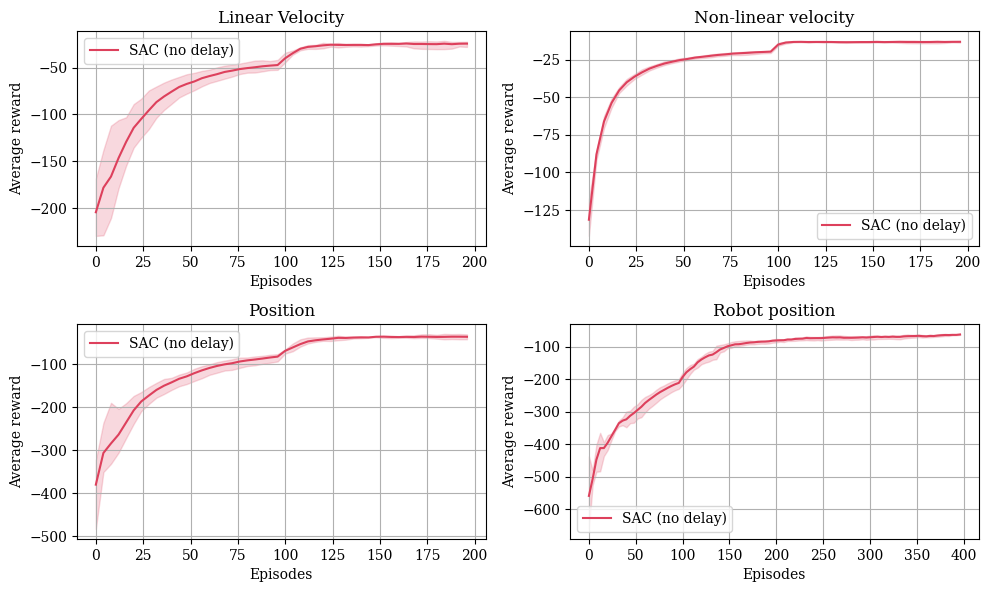

In [29]:
# 2 by 2 plot
f, ax = plt.subplots(2,2, figsize = (10,6))
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
titles = ['Linear Velocity', 'Non-linear velocity', 'Position', 'Robot position']

for e, env_name in enumerate(env_names):  
    print(f"Plotting env {env_name} with {e} and {e%2, e%1}")
    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg= np.mean(res, axis = 0)

        ax[(e//2)%2, e%2].plot(range(0, len(r_avg ) * 4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[(e//2)%2, e%2].fill_between(range(0, len(r_avg ) * 4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
        
    ax[(e//2)%2, e%2].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))])
    ax[(e//2)%2, e%2].grid()
    ax[(e//2)%2, e%2].set_title(titles[e])
    ax[(e//2)%2, e%2].set_xlabel('Episodes')
    ax[(e//2)%2, e%2].set_ylabel('Average reward')
f.tight_layout(pad = 1.0)

### Delay-safe agents

Setpoint dict {'LinearVelocity': [2.6141, 2.6142, 2.6143], 'NonLinearVelocity': [2.6141, 2.6142, 2.6143], 'Position': [[0.0, 2.6141], [0.0, 2.6142], [0.0, 2.6143]], 'RobotSteer': [[2.6181, 2.6181], [2.6182, 2.6182], [2.6183, 2.6183]], 'SphericalTank': [2.6261, 2.6262, 2.6263]}
Plotting env LinearVelocity with 0 and (0, 0)
Plotting env NonLinearVelocity with 1 and (1, 0)
Plotting env Position with 2 and (0, 0)
Plotting env RobotSteer with 3 and (1, 0)


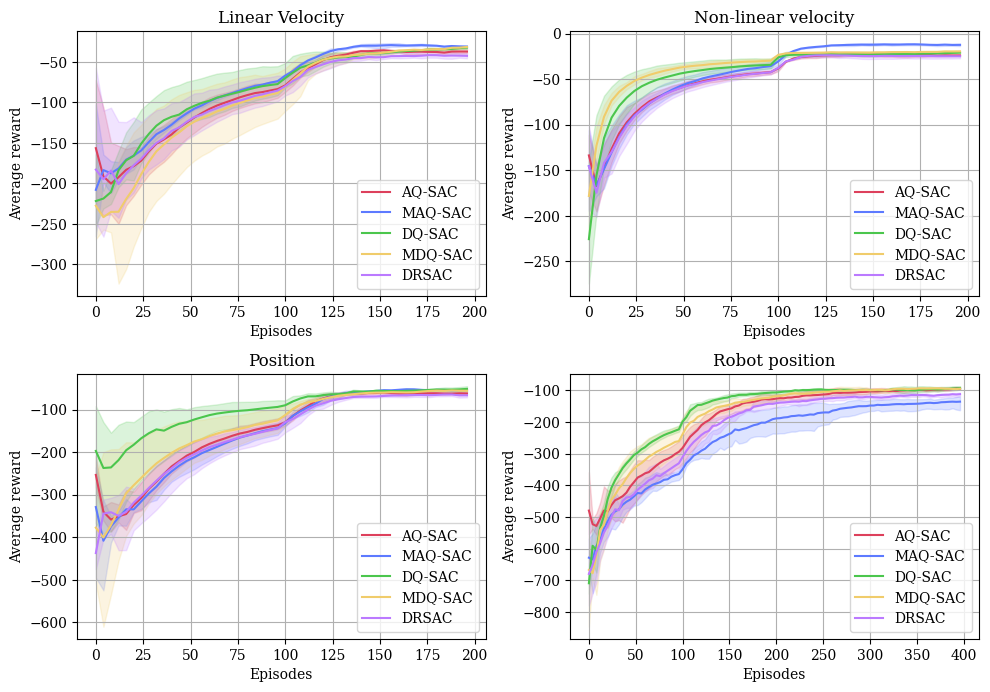

In [42]:
# 2 by 2 plot
env_dates_dict = {
    'LinearVelocity' : ['0614','0614','0614'], 
    'NonLinearVelocity' : ['0614','0614','0615'], 
    'Position' : ['0615','0615','0615'], 
    'RobotSteer' : ['0619','0619','0619'],
    'SphericalTank' : ['0626','0626','0626'], 
    'ShipVelocity' : ['0925','0925','0925']
}

setpoints = [2.6141, 2.6142, 2.6143]
env_setpoint_dict = {
    'LinearVelocity' : setpoints, 
    'NonLinearVelocity' : setpoints, 
    'Position' : [[0.0, setpoint] for setpoint in setpoints], 
    'RobotSteer' :[[setpoint, setpoint] for setpoint in [2.6181, 2.6182, 2.6183]],
    'SphericalTank' : [2.6261, 2.6262, 2.6263], 
    
}


print(f"Setpoint dict {env_setpoint_dict}")

agent_types = ['aqsac','maqsac', 'dqsac','mdqsac','drsac']
agent_official_names = {
    'sac' : 'SAC (no delay)',
    'aqsac' : 'AQ-SAC',
    'maqsac' : 'MAQ-SAC',
    'dqsac' : 'DQ-SAC',
    'mdqsac' : 'MDQ-SAC',
    'drsac' : 'DRSAC'
}

env_names = list(env_dates_dict.keys())


env_dict = {}
for env_name in env_names:
    agent_dict = {}
    dates = env_dates_dict[env_name]
    for agent_type in agent_types:
        run_arr = []
        for i in range(len(setpoints)) : 
            df = pd.read_csv(f'logs\\train\\{env_name}\\setpoint-error\\randomised\\{dates[i]}\\Desired{env_setpoint_dict[env_name][i]}\\{agent_type}\\progress.csv')
            run_arr.append(np.array(df['rollout/ep_rew_mean']))

        min_len = min([len(run_arr[k]) for k in range(len(run_arr))])
        run_arr = [run_arr[k][:50 if len(run_arr[k]) - 50 < 20 else len(run_arr[k])] for k in range(len(run_arr))]
        agent_dict[agent_type] = run_arr

    env_dict[env_name] = agent_dict

# Exclude spherical tank for this plot
env_names.remove('SphericalTank')

f, ax = plt.subplots(2,2, figsize = (10,7))

colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
titles = ['Linear Velocity', 'Non-linear velocity', 'Position', 'Robot position']

for e, env_name in enumerate(env_names):  
    print(f"Plotting env {env_name} with {e} and {e%2, e%1}")
    for i, agent_type in enumerate(agent_types) : 
        # print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg= np.mean(res, axis = 0)

        ax[(e//2)%2, e%2].plot(range(0, len(r_avg ) * 4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[(e//2)%2, e%2].fill_between(range(0, len(r_avg ) * 4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
        
    ax[(e//2)%2, e%2].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))])
    ax[(e//2)%2, e%2].grid()
    ax[(e//2)%2, e%2].set_title(titles[e])
    ax[(e//2)%2, e%2].set_xlabel('Episodes')
    ax[(e//2)%2, e%2].set_ylabel('Average reward')
f.tight_layout(pad = 1.0)

### Delay-safe agents for spherical tank

Data for SphericalTank and aqsac, data with len [50, 50, 50]
Data for SphericalTank and maqsac, data with len [50, 50, 50]
Data for SphericalTank and dqsac, data with len [50, 50, 50]
Data for SphericalTank and mdqsac, data with len [50, 50, 50]
Data for SphericalTank and drsac, data with len [50, 50, 50]
Len 26
Len 26
Len 26
Len 26
Len 26


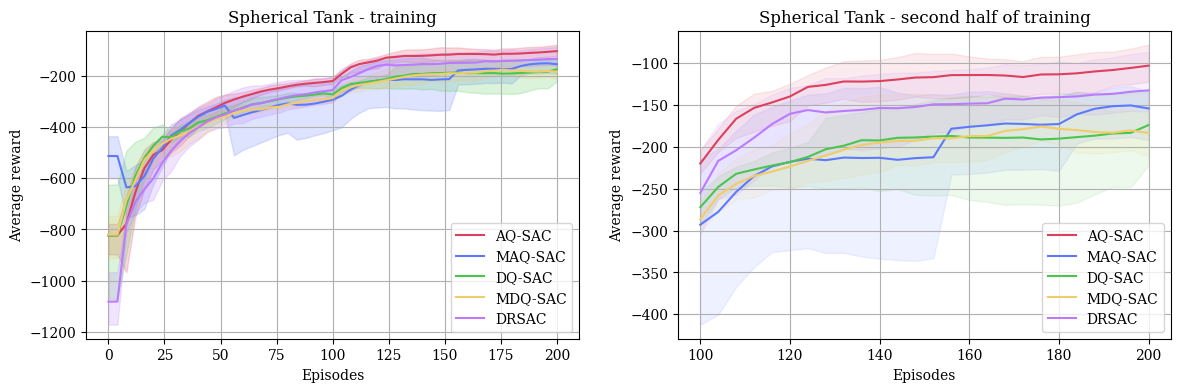

In [44]:
agent_types = ['aqsac','maqsac', 'dqsac','mdqsac','drsac']
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
env_names = ['SphericalTank']
f, ax = plt.subplots(len(env_names),2, figsize = (14,4))
for e, env_name in enumerate(env_names):
    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg = np.mean(res, axis = 0)

        # Add an element in the beginning
        r_avg = np.concatenate([[r_avg[0]], r_avg])
        r_min = np.concatenate([[r_min[0]], r_min])
        r_max = np.concatenate([[r_max[0]], r_max])
        ax[0].plot(range(0,len(r_avg)*4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[0].fill_between(range(0,len(r_avg)*4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
    ax[0].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))] , loc = 'lower right')
    ax[0].grid()
    ax[0].set_title('Spherical Tank - training')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Average reward')

    for i, agent_type in enumerate(agent_types) : 
        # print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)[24:]
        r_max = np.max(res, axis = 0)[24:]
        r_avg= np.mean(res, axis = 0)[24:]

        print(f"Len {len(range(100,100 + len(r_avg)*4, 4))}")
        ax[1].plot(range(100,100 + len(r_avg)*4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[1].fill_between(range(100,100 + (len(r_avg))*4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .1, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
    ax[1].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))], loc = 'lower right')
    ax[1].grid()
    ax[1].set_title('Spherical Tank - second half of training')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Average reward')